1. 주식 데이터
4개의 입력 변수 -> 1개의 출력 변수(close)
train, test

Tensorflow

In [ ]:
import tensorflow
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [196]:
import pandas as pd
import pandas_datareader as pdr
# 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
def get_code(df, name):
    code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
# 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거
    code = code.strip()
    return code
# excel 파일을 다운로드하는거와 동시에 pandas에 load하기
# 흔히 사용하는 df라는 변수는 data frame을 의미합니다.
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
# data frame정리
code_df = code_df[['회사명', '종목코드']]
# data frame title 변경 '회사명' = name, 종목코드 = 'code'
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'})
# 종목코드는 6자리로 구분되기때문에 0을 채워 6자리로 변경
code_df.code = code_df.code.map('{:06d}'.format)
# ex) 삼성전자의의 코드를 구해보겠습니다.
code = get_code(code_df, '삼성전자')
# yahoo의 주식 데이터 종목은 코스피는 .KS, 코스닥은 .KQ가 붙습니다.
# 삼성전자의 경우 코스피에 상장되어있기때문에 '종목코드.KS'로 처리하도록 한다.
code = code + '.KS'

In [197]:
# get_data_yahoo API를 통해서 yahho finance의 주식 종목 데이터를 가져온다.
df = pdr.get_data_yahoo(code)
df.drop(['Adj Close'], axis=1, inplace=True)
df = df.iloc[:-2,:]
df

,High,Low,Open,Close,Volume
Date,,,,,
2015-04-20,28960.0,28460.0,28920.0,28600.0,12394900.0
2015-04-21,28900.0,28400.0,28420.0,28880.0,11852650.0
2015-04-22,29460.0,28720.0,28880.0,29220.0,12655550.0
2015-04-23,29400.0,28800.0,29400.0,29020.0,9245150.0
2015-04-24,29100.0,28000.0,28980.0,28200.0,19089900.0
...,...,...,...,...,...
2020-03-05,58000.0,56700.0,57600.0,57800.0,21698990.0
2020-03-06,57200.0,56200.0,56500.0,56500.0,18716656.0
2020-03-09,56500.0,56500.0,56500.0,56500.0,0.0


In [198]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

Regression Problem

In [199]:
xdata = df[['High','Low','Open','Volume']]
ydata = df[['Close']]
print(xdata.shape, ydata.shape)

(1196, 4) (1196, 1)


In [200]:
# idx = int(len(xdata) * 0.1)
# xData = xdata.iloc[:len(xdata)-idx]
# yData = ydata.iloc[:len(ydata)-idx]
# xTest = xdata.iloc[len(xdata)-idx:]
# yTest = ydata.iloc[len(ydata)-idx:]
# print(xData.shape, yData.shape, xTest.shape, yTest.shape)
xData, yData = xdata, ydata

In [201]:
xTrn, xTst, yTrn, yTst = train_test_split(xData, yData, 
                                          test_size=0.3,
                                         shuffle=False)

In [202]:
X = tf.placeholder(tf.float32, shape=[None, 4])
Y = tf.placeholder(tf.float32, shape=[None, 1])
W = tf.Variable(tf.random_normal([4,1]))
b = tf.Variable(tf.random_normal([1]))

hf = tf.matmul(X,W)+b
cost = tf.reduce_mean(tf.square(hf-Y))
opt = tf.train.AdamOptimizer(0.001)
train = opt.minimize(cost)

In [203]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(20000):
        _, cv = sess.run([train, cost],
                        feed_dict={X:xTrn
                                  ,Y:yTrn})
        if step % 500 == 0:
            print(step, cv)
    hfv, cv = sess.run([hf, cost], feed_dict={X:xTst, Y:yTst})
    print(cv)

0 738729950000000.0
500 431630220000000.0
1000 231323780000000.0
1500 110181300000000.0
2000 44605120000000.0
2500 14427106000000.0
3000 3437431400000.0
3500 553432500000.0
4000 66679534000.0
4500 20382513000.0
5000 18117585000.0
5500 17857510000.0
6000 17574074000.0
6500 17216825000.0
7000 16768804000.0
7500 16210961000.0
8000 15522767000.0
8500 14683801000.0
9000 13676593000.0
9500 12491020000.0
10000 11130158000.0
10500 9616914000.0
11000 7999132000.0
11500 6350403600.0
12000 4763234300.0
12500 3334222000.0
13000 2144438400.0
13500 1241419900.0
14000 628989400.0
14500 268409680.0
15000 91631710.0
15500 23528964.0
16000 4433266.0
16500 896332.0
17000 512699.1
17500 491699.38
18000 491128.44
18500 490999.4
19000 490833.44
19500 490622.62
702620.44


In [204]:
print((np.array(yTst)-hfv).mean())
print((np.array(yTst)-hfv).sum())

142.5349930362117
51170.0625


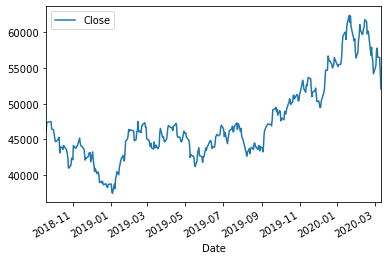

In [205]:
yTst.plot()

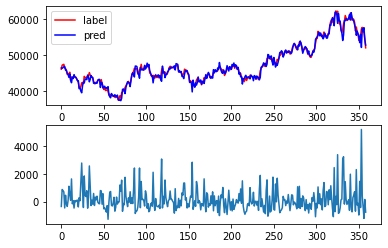

In [207]:
fig, axes = plt.subplots(2)
axes[0].plot(np.array(yTst), color='r', label='label')
axes[0].plot(np.array(hfv), color='b', label='pred')
axes[0].legend()

axes[1].plot(np.array(yTst)-hfv)
plt.show()

Keras

In [208]:
# get_data_yahoo API를 통해서 yahho finance의 주식 종목 데이터를 가져온다.
df = pdr.get_data_yahoo(code)
df.drop(['Adj Close'], axis=1, inplace=True)
df = df.iloc[:-2,:]
df

,High,Low,Open,Close,Volume
Date,,,,,
2015-04-20,28960.0,28460.0,28920.0,28600.0,12394900.0
2015-04-21,28900.0,28400.0,28420.0,28880.0,11852650.0
2015-04-22,29460.0,28720.0,28880.0,29220.0,12655550.0
2015-04-23,29400.0,28800.0,29400.0,29020.0,9245150.0
2015-04-24,29100.0,28000.0,28980.0,28200.0,19089900.0
...,...,...,...,...,...
2020-03-05,58000.0,56700.0,57600.0,57800.0,21698990.0
2020-03-06,57200.0,56200.0,56500.0,56500.0,18716656.0
2020-03-09,56500.0,56500.0,56500.0,56500.0,0.0


In [209]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
xdata = scaler.fit_transform(xdata)

In [210]:
xdata = df[['High','Low','Open','Volume']]
ydata = df[['Close']]
print(xdata.shape, ydata.shape)

(1196, 4) (1196, 1)


In [211]:
xdata = xdata.astype('float32')
ydata = ydata.astype('float32')

In [212]:
# 10% Test data로 사용
# 90%를 7:3 으로 train, validation 나눔

idx = int(len(xdata) * 0.1)
xData = xdata.iloc[:len(xdata)-idx]
yData = ydata.iloc[:len(ydata)-idx]
xTest = xdata.iloc[len(xdata)-idx:]
yTest = ydata.iloc[len(ydata)-idx:]
print(xData.shape, yData.shape, xTest.shape, yTest.shape)

xTrn, xTst, yTrn, yTst = train_test_split(xData, yData, 
                                          test_size=0.3,
                                          shuffle=False)

(1077, 4) (1077, 1) (119, 4) (119, 1)


In [213]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

In [214]:
model.compile(loss='mae', optimizer='adam'
             , metrics=['mae'])

In [215]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=50)
# EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [216]:
hist = model.fit(xTrn, yTrn, batch_size=8
                , epochs=1000
                , validation_data=(xTst,yTst)
                , callbacks=[es])

Train on 753 samples, validate on 324 samples
Epoch 1/1000
753/753 [==============================] - 1s 898us/step - loss: 34415.5806 - mae: 34415.5742 - val_loss: 34268.6419 - val_mae: 34268.6406
Epoch 2/1000
753/753 [==============================] - 0s 366us/step - loss: 17131.2321 - mae: 17131.2305 - val_loss: 19090.1669 - val_mae: 19090.1660
Epoch 3/1000
753/753 [==============================] - 0s 311us/step - loss: 16208.5310 - mae: 16208.5273 - val_loss: 21073.1480 - val_mae: 21073.1504
Epoch 4/1000
753/753 [==============================] - 0s 349us/step - loss: 15869.0739 - mae: 15869.0742 - val_loss: 16427.6809 - val_mae: 16427.6797
Epoch 5/1000
753/753 [==============================] - 0s 328us/step - loss: 15151.1594 - mae: 15151.1621 - val_loss: 13018.2482 - val_mae: 13018.2480
Epoch 6/1000
753/753 [==============================] - 0s 340us/step - loss: 14530.5091 - mae: 14530.5088 - val_loss: 19382.2536 - val_mae: 19382.2539
Epoch 7/1000
753/753 [====================

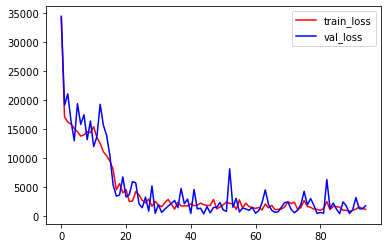

In [217]:
import matplotlib.pyplot as plt

figs, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], color='r', label='train_loss')
loss_ax.plot(hist.history['val_loss'], color='b', label='val_loss')
loss_ax.legend(loc='upper right')
plt.show()

In [218]:
result = model.evaluate(xTest, yTest, batch_size=3)
print(result)

119/119 [==============================] - 0s 335us/step
[2277.5522871257876, 2277.55224609375]


In [219]:
pred = model.predict(xTest)

In [220]:
np.array(yTest)
print(np.array(yTest).shape)

(119, 1)


In [221]:
pred.shape

(119, 1)

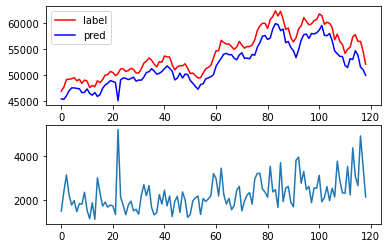

In [222]:
fig, axes = plt.subplots(2)
axes[0].plot(np.array(yTest), color='r', label='label')
axes[0].plot(pred, color='b', label='pred')
axes[0].legend()

axes[1].plot(np.array(yTest)-pred)
plt.show()

In [223]:
(np.array(yTest)-pred).mean()

2277.5515

# 2. tree.csv

Girth, Height => Volumn 예측

In [245]:
path = r"C:\Users\chan\Desktop\dataset"
trees = pd.read_csv(path + "\\trees.csv")

In [260]:
trees

,Girth,Height,Volume
0,8.3,70,10.3
1,8.6,65,10.3
2,8.8,63,10.2
3,10.5,72,16.4
4,10.7,81,18.8
5,10.8,83,19.7
6,11.0,66,15.6
7,11.0,75,18.2
8,11.1,80,22.6
9,11.2,75,19.9


In [271]:
xdata = trees.iloc[:,:-1].astype('float32')
ydata = trees.iloc[:,-1].astype('float32')

In [272]:
xTrn, xTst, yTrn, yTst = train_test_split(xdata, ydata, test_size=0.3)

In [273]:
model = Sequential()
model.add(Dense(64, input_shape=(2,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [274]:
model.compile(loss='mae',metrics=['mae'], optimizer='adam')

In [275]:
es = EarlyStopping(monitor='val_loss', patience=50)
hist = model.fit(xTrn, yTrn,
                  batch_size=32,
                  epochs=2000,
                  validation_split=0.1, callbacks=[es])

Train on 18 samples, validate on 3 samples
Epoch 1/2000
18/18 [==============================] - 0s 27ms/step - loss: 34.4010 - mae: 34.4010 - val_loss: 32.4789 - val_mae: 32.4789
Epoch 2/2000
18/18 [==============================] - 0s 334us/step - loss: 32.1720 - mae: 32.1720 - val_loss: 31.2808 - val_mae: 31.2808
Epoch 3/2000
18/18 [==============================] - 0s 333us/step - loss: 30.9922 - mae: 30.9922 - val_loss: 30.0486 - val_mae: 30.0486
Epoch 4/2000
18/18 [==============================] - 0s 334us/step - loss: 29.7880 - mae: 29.7880 - val_loss: 28.8670 - val_mae: 28.8670
Epoch 5/2000
18/18 [==============================] - 0s 444us/step - loss: 28.6311 - mae: 28.6311 - val_loss: 28.1443 - val_mae: 28.1443
Epoch 6/2000
18/18 [==============================] - 0s 389us/step - loss: 27.9170 - mae: 27.9170 - val_loss: 27.1453 - val_mae: 27.1453
Epoch 7/2000
18/18 [==============================] - 0s 390us/step - loss: 26.9421 - mae: 26.9421 - val_loss: 26.0325 - val_mae: 

Epoch 61/2000
18/18 [==============================] - 0s 332us/step - loss: 11.9960 - mae: 11.9960 - val_loss: 6.5457 - val_mae: 6.5457
Epoch 62/2000
18/18 [==============================] - 0s 223us/step - loss: 12.0091 - mae: 12.0091 - val_loss: 6.2608 - val_mae: 6.2608
Epoch 63/2000
18/18 [==============================] - 0s 278us/step - loss: 12.0125 - mae: 12.0125 - val_loss: 6.1556 - val_mae: 6.1556
Epoch 64/2000
18/18 [==============================] - 0s 281us/step - loss: 12.0075 - mae: 12.0075 - val_loss: 6.5534 - val_mae: 6.5534
Epoch 65/2000
18/18 [==============================] - 0s 279us/step - loss: 11.9700 - mae: 11.9700 - val_loss: 7.0691 - val_mae: 7.0691


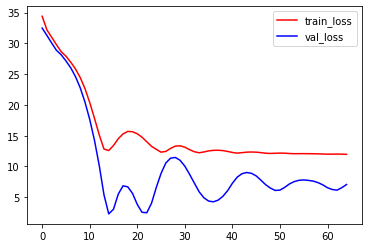

In [279]:
import matplotlib.pyplot as plt

figs, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], color='r', label='train_loss')
loss_ax.plot(hist.history['val_loss'], color='b', label='val_loss')
loss_ax.legend(loc='upper right')
plt.show()

In [280]:
model.evaluate(xTst, yTst)

10/10 [==============================] - 0s 199us/step


[10.395183563232422, 10.395183563232422]

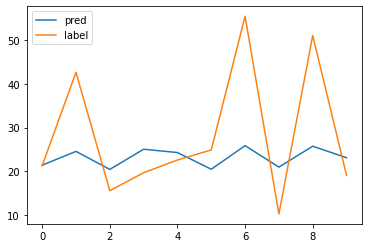

In [281]:
plt.plot(model.predict(xTst), label='pred')
plt.plot(yTst.reset_index(drop=True), label='label')
plt.legend()
plt.show()

너무 안맞음 경향도 안맞는 것을 볼 수 있음
데이터 갯수가 너무 적어서 train, val을 안나누고 진행

In [282]:
es = EarlyStopping(monitor='val_loss', patience=50)
hist = model.fit(xTrn, yTrn,
                  batch_size=32,
                  epochs=2000)

Epoch 1/2000
21/21 [==============================] - 0s 190us/step - loss: 11.2462 - mae: 11.2462
Epoch 2/2000
21/21 [==============================] - 0s 142us/step - loss: 11.2227 - mae: 11.2227
Epoch 3/2000
21/21 [==============================] - 0s 190us/step - loss: 11.1467 - mae: 11.1467
Epoch 4/2000
21/21 [==============================] - 0s 142us/step - loss: 11.1132 - mae: 11.1132
Epoch 5/2000
21/21 [==============================] - 0s 142us/step - loss: 11.1046 - mae: 11.1046
Epoch 6/2000
21/21 [==============================] - 0s 142us/step - loss: 11.0962 - mae: 11.0962
Epoch 7/2000
21/21 [==============================] - 0s 141us/step - loss: 11.0837 - mae: 11.0837
Epoch 8/2000
21/21 [==============================] - 0s 143us/step - loss: 11.0986 - mae: 11.0986
Epoch 9/2000
21/21 [==============================] - 0s 144us/step - loss: 11.0825 - mae: 11.0825
Epoch 10/2000
21/21 [==============================] - 0s 143us/step - loss: 11.0380 - mae: 11.0380
Epoch 11/

21/21 [==============================] - 0s 95us/step - loss: 4.0933 - mae: 4.0933
Epoch 85/2000
21/21 [==============================] - 0s 190us/step - loss: 3.9485 - mae: 3.9485
Epoch 86/2000
21/21 [==============================] - 0s 95us/step - loss: 3.9574 - mae: 3.9574
Epoch 87/2000
21/21 [==============================] - 0s 143us/step - loss: 3.9360 - mae: 3.9360
Epoch 88/2000
21/21 [==============================] - 0s 142us/step - loss: 3.8238 - mae: 3.8238
Epoch 89/2000
21/21 [==============================] - 0s 143us/step - loss: 3.9158 - mae: 3.9158
Epoch 90/2000
21/21 [==============================] - 0s 142us/step - loss: 4.1356 - mae: 4.1356
Epoch 91/2000
21/21 [==============================] - 0s 190us/step - loss: 3.7548 - mae: 3.7548
Epoch 92/2000
21/21 [==============================] - 0s 95us/step - loss: 4.1371 - mae: 4.1371
Epoch 93/2000
21/21 [==============================] - 0s 142us/step - loss: 3.7669 - mae: 3.7669
Epoch 94/2000
21/21 [================

Epoch 168/2000
21/21 [==============================] - 0s 95us/step - loss: 3.5224 - mae: 3.5224
Epoch 169/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5281 - mae: 3.5281
Epoch 170/2000
21/21 [==============================] - 0s 95us/step - loss: 3.6317 - mae: 3.6317
Epoch 171/2000
21/21 [==============================] - 0s 142us/step - loss: 3.6389 - mae: 3.6389
Epoch 172/2000
21/21 [==============================] - 0s 95us/step - loss: 3.6382 - mae: 3.6382
Epoch 173/2000
21/21 [==============================] - 0s 95us/step - loss: 3.5486 - mae: 3.5486
Epoch 174/2000
21/21 [==============================] - 0s 143us/step - loss: 3.5650 - mae: 3.5650
Epoch 175/2000
21/21 [==============================] - 0s 141us/step - loss: 3.7966 - mae: 3.7966
Epoch 176/2000
21/21 [==============================] - 0s 95us/step - loss: 3.5344 - mae: 3.5344
Epoch 177/2000
21/21 [==============================] - 0s 190us/step - loss: 3.8024 - mae: 3.8024
Epoch 178/2000


Epoch 251/2000
21/21 [==============================] - 0s 143us/step - loss: 3.5839 - mae: 3.5839
Epoch 252/2000
21/21 [==============================] - 0s 143us/step - loss: 3.4105 - mae: 3.4105
Epoch 253/2000
21/21 [==============================] - 0s 142us/step - loss: 3.4987 - mae: 3.4987
Epoch 254/2000
21/21 [==============================] - 0s 145us/step - loss: 3.5080 - mae: 3.5080
Epoch 255/2000
21/21 [==============================] - 0s 95us/step - loss: 3.4134 - mae: 3.4134
Epoch 256/2000
21/21 [==============================] - 0s 95us/step - loss: 3.5836 - mae: 3.5836
Epoch 257/2000
21/21 [==============================] - 0s 142us/step - loss: 3.4227 - mae: 3.4227
Epoch 258/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3871 - mae: 3.3871
Epoch 259/2000
21/21 [==============================] - 0s 95us/step - loss: 3.3871 - mae: 3.3871
Epoch 260/2000
21/21 [==============================] - 0s 143us/step - loss: 3.4680 - mae: 3.4680
Epoch 261/200

Epoch 335/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3981 - mae: 3.3981
Epoch 336/2000
21/21 [==============================] - 0s 95us/step - loss: 3.4038 - mae: 3.4038
Epoch 337/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3057 - mae: 3.3057
Epoch 338/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5114 - mae: 3.5114
Epoch 339/2000
21/21 [==============================] - 0s 95us/step - loss: 3.3268 - mae: 3.3268
Epoch 340/2000
21/21 [==============================] - 0s 142us/step - loss: 3.4012 - mae: 3.4012
Epoch 341/2000
21/21 [==============================] - 0s 95us/step - loss: 3.5045 - mae: 3.5045
Epoch 342/2000
21/21 [==============================] - 0s 95us/step - loss: 3.3764 - mae: 3.3764
Epoch 343/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5080 - mae: 3.5080
Epoch 344/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3334 - mae: 3.3334
Epoch 345/2000

Epoch 418/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3390 - mae: 3.3390
Epoch 419/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2633 - mae: 3.2633
Epoch 420/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2719 - mae: 3.2719
Epoch 421/2000
21/21 [==============================] - 0s 190us/step - loss: 3.2896 - mae: 3.2896
Epoch 422/2000
21/21 [==============================] - 0s 143us/step - loss: 3.2357 - mae: 3.2357
Epoch 423/2000
21/21 [==============================] - 0s 190us/step - loss: 3.2475 - mae: 3.2475
Epoch 424/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2455 - mae: 3.2455
Epoch 425/2000
21/21 [==============================] - 0s 190us/step - loss: 3.2338 - mae: 3.2338
Epoch 426/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2515 - mae: 3.2515
Epoch 427/2000
21/21 [==============================] - 0s 143us/step - loss: 3.2346 - mae: 3.2346
Epoch 428/

Epoch 501/2000
21/21 [==============================] - 0s 190us/step - loss: 3.3269 - mae: 3.3269
Epoch 502/2000
21/21 [==============================] - 0s 142us/step - loss: 3.4741 - mae: 3.4741
Epoch 503/2000
21/21 [==============================] - 0s 190us/step - loss: 3.4204 - mae: 3.4204
Epoch 504/2000
21/21 [==============================] - 0s 190us/step - loss: 3.3501 - mae: 3.3501
Epoch 505/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3402 - mae: 3.3402
Epoch 506/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2228 - mae: 3.2228
Epoch 507/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2238 - mae: 3.2238
Epoch 508/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3080 - mae: 3.3080
Epoch 509/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3984 - mae: 3.3984
Epoch 510/2000
21/21 [==============================] - 0s 143us/step - loss: 3.1841 - mae: 3.1841
Epoch 511/

Epoch 584/2000
21/21 [==============================] - 0s 190us/step - loss: 3.3727 - mae: 3.3727
Epoch 585/2000
21/21 [==============================] - 0s 95us/step - loss: 3.1280 - mae: 3.1280
Epoch 586/2000
21/21 [==============================] - 0s 143us/step - loss: 3.2810 - mae: 3.2810
Epoch 587/2000
21/21 [==============================] - 0s 143us/step - loss: 3.0971 - mae: 3.0971
Epoch 588/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3609 - mae: 3.3609
Epoch 589/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5729 - mae: 3.5729
Epoch 590/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3774 - mae: 3.3774
Epoch 591/2000
21/21 [==============================] - 0s 142us/step - loss: 3.8465 - mae: 3.8465
Epoch 592/2000
21/21 [==============================] - 0s 143us/step - loss: 3.1328 - mae: 3.1328
Epoch 593/2000
21/21 [==============================] - 0s 95us/step - loss: 3.3635 - mae: 3.3635
Epoch 594/20

Epoch 751/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0418 - mae: 3.0418
Epoch 752/2000
21/21 [==============================] - 0s 141us/step - loss: 3.2509 - mae: 3.2509
Epoch 753/2000
21/21 [==============================] - 0s 189us/step - loss: 3.0866 - mae: 3.0866
Epoch 754/2000
21/21 [==============================] - 0s 144us/step - loss: 3.6976 - mae: 3.6976
Epoch 755/2000
21/21 [==============================] - 0s 143us/step - loss: 3.0298 - mae: 3.0298
Epoch 756/2000
21/21 [==============================] - 0s 142us/step - loss: 3.6512 - mae: 3.6512
Epoch 757/2000
21/21 [==============================] - 0s 143us/step - loss: 3.3919 - mae: 3.3919
Epoch 758/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1988 - mae: 3.1988
Epoch 759/2000
21/21 [==============================] - 0s 142us/step - loss: 3.9400 - mae: 3.9400
Epoch 760/2000
21/21 [==============================] - 0s 141us/step - loss: 3.2230 - mae: 3.2230
Epoch 761/

Epoch 834/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1236 - mae: 3.1236
Epoch 835/2000
21/21 [==============================] - 0s 190us/step - loss: 3.2583 - mae: 3.2583
Epoch 836/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9153 - mae: 2.9153
Epoch 837/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8884 - mae: 2.8884
Epoch 838/2000
21/21 [==============================] - 0s 134us/step - loss: 2.9440 - mae: 2.9440
Epoch 839/2000
21/21 [==============================] - 0s 144us/step - loss: 2.9636 - mae: 2.9636
Epoch 840/2000
21/21 [==============================] - 0s 143us/step - loss: 2.8647 - mae: 2.8647
Epoch 841/2000
21/21 [==============================] - 0s 149us/step - loss: 2.8687 - mae: 2.8687
Epoch 842/2000
21/21 [==============================] - 0s 143us/step - loss: 2.9339 - mae: 2.9339
Epoch 843/2000
21/21 [==============================] - 0s 143us/step - loss: 2.9827 - mae: 2.9827
Epoch 844/

Epoch 917/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0835 - mae: 3.0835
Epoch 918/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9808 - mae: 2.9808
Epoch 919/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3303 - mae: 3.3303
Epoch 920/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8672 - mae: 2.8672
Epoch 921/2000
21/21 [==============================] - 0s 143us/step - loss: 3.2279 - mae: 3.2279
Epoch 922/2000
21/21 [==============================] - 0s 95us/step - loss: 3.0891 - mae: 3.0891
Epoch 923/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1365 - mae: 3.1365
Epoch 924/2000
21/21 [==============================] - 0s 141us/step - loss: 2.8688 - mae: 2.8688
Epoch 925/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9724 - mae: 2.9724
Epoch 926/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8597 - mae: 2.8597
Epoch 927/20

Epoch 1001/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9952 - mae: 2.9952
Epoch 1002/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8686 - mae: 2.8686
Epoch 1003/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3292 - mae: 3.3292
Epoch 1004/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9349 - mae: 2.9349
Epoch 1005/2000
21/21 [==============================] - 0s 143us/step - loss: 2.8665 - mae: 2.8665
Epoch 1006/2000
21/21 [==============================] - 0s 95us/step - loss: 3.2588 - mae: 3.2588
Epoch 1007/2000
21/21 [==============================] - 0s 143us/step - loss: 2.8722 - mae: 2.8722
Epoch 1008/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0802 - mae: 3.0802
Epoch 1009/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9442 - mae: 2.9442
Epoch 1010/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9925 - mae: 2.9925
Epo

Epoch 1084/2000
21/21 [==============================] - 0s 142us/step - loss: 3.2309 - mae: 3.2309
Epoch 1085/2000
21/21 [==============================] - 0s 95us/step - loss: 2.8787 - mae: 2.8787
Epoch 1086/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1679 - mae: 3.1679
Epoch 1087/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8176 - mae: 2.8176
Epoch 1088/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9607 - mae: 2.9607
Epoch 1089/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7848 - mae: 2.7848
Epoch 1090/2000
21/21 [==============================] - 0s 143us/step - loss: 3.1668 - mae: 3.1668
Epoch 1091/2000
21/21 [==============================] - 0s 190us/step - loss: 2.9329 - mae: 2.9329
Epoch 1092/2000
21/21 [==============================] - 0s 94us/step - loss: 2.9482 - mae: 2.9482
Epoch 1093/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9158 - mae: 2.9158
Ep

Epoch 1166/2000
21/21 [==============================] - 0s 190us/step - loss: 2.7990 - mae: 2.7990
Epoch 1167/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5760 - mae: 3.5760
Epoch 1168/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0025 - mae: 3.0025
Epoch 1169/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3434 - mae: 3.3434
Epoch 1170/2000
21/21 [==============================] - 0s 189us/step - loss: 3.6759 - mae: 3.6759
Epoch 1171/2000
21/21 [==============================] - 0s 143us/step - loss: 2.9150 - mae: 2.9150
Epoch 1172/2000
21/21 [==============================] - 0s 143us/step - loss: 3.4468 - mae: 3.4468
Epoch 1173/2000
21/21 [==============================] - 0s 143us/step - loss: 3.2951 - mae: 3.2951
Epoch 1174/2000
21/21 [==============================] - 0s 143us/step - loss: 3.0726 - mae: 3.0726
Epoch 1175/2000
21/21 [==============================] - 0s 142us/step - loss: 3.5619 - mae: 3.5619


21/21 [==============================] - 0s 142us/step - loss: 3.0526 - mae: 3.0526
Epoch 1249/2000
21/21 [==============================] - 0s 190us/step - loss: 2.7955 - mae: 2.7955
Epoch 1250/2000
21/21 [==============================] - 0s 95us/step - loss: 3.1268 - mae: 3.1268
Epoch 1251/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7522 - mae: 2.7522
Epoch 1252/2000
21/21 [==============================] - 0s 142us/step - loss: 3.6116 - mae: 3.6116
Epoch 1253/2000
21/21 [==============================] - 0s 95us/step - loss: 2.8594 - mae: 2.8594
Epoch 1254/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3917 - mae: 3.3917
Epoch 1255/2000
21/21 [==============================] - 0s 142us/step - loss: 3.4053 - mae: 3.4053
Epoch 1256/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1706 - mae: 3.1706
Epoch 1257/2000
21/21 [==============================] - 0s 190us/step - loss: 3.4502 - mae: 3.4502
Epoch 1258/2000
21

Epoch 1331/2000
21/21 [==============================] - 0s 143us/step - loss: 2.6612 - mae: 2.6612
Epoch 1332/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6288 - mae: 2.6288
Epoch 1333/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6428 - mae: 2.6428
Epoch 1334/2000
21/21 [==============================] - 0s 95us/step - loss: 2.7043 - mae: 2.7043
Epoch 1335/2000
21/21 [==============================] - 0s 95us/step - loss: 3.0190 - mae: 3.0190
Epoch 1336/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8311 - mae: 2.8311
Epoch 1337/2000
21/21 [==============================] - 0s 95us/step - loss: 3.0992 - mae: 3.0992
Epoch 1338/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7667 - mae: 2.7667
Epoch 1339/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9524 - mae: 2.9524
Epoch 1340/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9262 - mae: 2.9262
Epoch 1

Epoch 1414/2000
21/21 [==============================] - 0s 95us/step - loss: 2.7322 - mae: 2.7322
Epoch 1415/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6212 - mae: 2.6212
Epoch 1416/2000
21/21 [==============================] - 0s 95us/step - loss: 2.7455 - mae: 2.7455
Epoch 1417/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6116 - mae: 2.6116
Epoch 1418/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6085 - mae: 2.6085
Epoch 1419/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5885 - mae: 2.5885
Epoch 1420/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5586 - mae: 2.5586
Epoch 1421/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6121 - mae: 2.6121
Epoch 1422/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6396 - mae: 2.6396
Epoch 1423/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6318 - mae: 2.6318
Epoch

Epoch 1497/2000
21/21 [==============================] - 0s 142us/step - loss: 3.3445 - mae: 3.3445
Epoch 1498/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1986 - mae: 3.1986
Epoch 1499/2000
21/21 [==============================] - 0s 95us/step - loss: 3.2529 - mae: 3.2529
Epoch 1500/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9820 - mae: 2.9820
Epoch 1501/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1605 - mae: 3.1605
Epoch 1502/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0605 - mae: 3.0605
Epoch 1503/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9160 - mae: 2.9160
Epoch 1504/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1361 - mae: 3.1361
Epoch 1505/2000
21/21 [==============================] - 0s 95us/step - loss: 3.3333 - mae: 3.3333
Epoch 1506/2000
21/21 [==============================] - 0s 95us/step - loss: 3.1526 - mae: 3.1526
Epo

Epoch 1580/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1333 - mae: 3.1333
Epoch 1581/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6883 - mae: 2.6883
Epoch 1582/2000
21/21 [==============================] - 0s 95us/step - loss: 2.9709 - mae: 2.9709
Epoch 1583/2000
21/21 [==============================] - 0s 143us/step - loss: 2.6960 - mae: 2.6960
Epoch 1584/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0179 - mae: 3.0179
Epoch 1585/2000
21/21 [==============================] - 0s 96us/step - loss: 3.1771 - mae: 3.1771
Epoch 1586/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7703 - mae: 2.7703
Epoch 1587/2000
21/21 [==============================] - 0s 191us/step - loss: 2.8652 - mae: 2.8652
Epoch 1588/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9357 - mae: 2.9357
Epoch 1589/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9477 - mae: 2.9477
Ep

Epoch 1663/2000
21/21 [==============================] - 0s 143us/step - loss: 2.7256 - mae: 2.7256
Epoch 1664/2000
21/21 [==============================] - 0s 237us/step - loss: 2.8614 - mae: 2.8614
Epoch 1665/2000
21/21 [==============================] - 0s 142us/step - loss: 3.1362 - mae: 3.1362
Epoch 1666/2000
21/21 [==============================] - 0s 142us/step - loss: 2.8609 - mae: 2.8609
Epoch 1667/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7442 - mae: 2.7442
Epoch 1668/2000
21/21 [==============================] - 0s 190us/step - loss: 3.1224 - mae: 3.1224
Epoch 1669/2000
21/21 [==============================] - 0s 190us/step - loss: 2.5979 - mae: 2.5979
Epoch 1670/2000
21/21 [==============================] - 0s 142us/step - loss: 2.9670 - mae: 2.9670
Epoch 1671/2000
21/21 [==============================] - 0s 142us/step - loss: 3.0298 - mae: 3.0298
Epoch 1672/2000
21/21 [==============================] - 0s 190us/step - loss: 2.5884 - mae: 2.5884


Epoch 1746/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4588 - mae: 2.4588
Epoch 1747/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5587 - mae: 2.5587
Epoch 1748/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6142 - mae: 2.6142
Epoch 1749/2000
21/21 [==============================] - 0s 143us/step - loss: 2.5472 - mae: 2.5472
Epoch 1750/2000
21/21 [==============================] - 0s 143us/step - loss: 2.6322 - mae: 2.6322
Epoch 1751/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4768 - mae: 2.4768
Epoch 1752/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6235 - mae: 2.6235
Epoch 1753/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4479 - mae: 2.4479
Epoch 1754/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6424 - mae: 2.6424
Epoch 1755/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4591 - mae: 2.4591


Epoch 1829/2000
21/21 [==============================] - 0s 95us/step - loss: 2.4892 - mae: 2.4892
Epoch 1830/2000
21/21 [==============================] - 0s 95us/step - loss: 2.4725 - mae: 2.4725
Epoch 1831/2000
21/21 [==============================] - 0s 143us/step - loss: 2.4256 - mae: 2.4256
Epoch 1832/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5800 - mae: 2.5800
Epoch 1833/2000
21/21 [==============================] - 0s 95us/step - loss: 2.4239 - mae: 2.4239
Epoch 1834/2000
21/21 [==============================] - 0s 95us/step - loss: 2.7712 - mae: 2.7712
Epoch 1835/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4009 - mae: 2.4009
Epoch 1836/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7928 - mae: 2.7928
Epoch 1837/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4294 - mae: 2.4294
Epoch 1838/2000
21/21 [==============================] - 0s 95us/step - loss: 2.5500 - mae: 2.5500
Epoch

Epoch 1912/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4893 - mae: 2.4893
Epoch 1913/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5882 - mae: 2.5882
Epoch 1914/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4489 - mae: 2.4489
Epoch 1915/2000
21/21 [==============================] - 0s 143us/step - loss: 2.5800 - mae: 2.5800
Epoch 1916/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4096 - mae: 2.4096
Epoch 1917/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4474 - mae: 2.4474
Epoch 1918/2000
21/21 [==============================] - 0s 143us/step - loss: 2.3981 - mae: 2.3981
Epoch 1919/2000
21/21 [==============================] - 0s 190us/step - loss: 2.4133 - mae: 2.4133
Epoch 1920/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4174 - mae: 2.4174
Epoch 1921/2000
21/21 [==============================] - 0s 142us/step - loss: 2.4018 - mae: 2.4018


Epoch 1994/2000
21/21 [==============================] - 0s 142us/step - loss: 2.6235 - mae: 2.6235
Epoch 1995/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5488 - mae: 2.5488
Epoch 1996/2000
21/21 [==============================] - 0s 143us/step - loss: 2.5619 - mae: 2.5619
Epoch 1997/2000
21/21 [==============================] - 0s 143us/step - loss: 2.4512 - mae: 2.4512
Epoch 1998/2000
21/21 [==============================] - 0s 95us/step - loss: 2.6506 - mae: 2.6506
Epoch 1999/2000
21/21 [==============================] - 0s 142us/step - loss: 2.5701 - mae: 2.5701
Epoch 2000/2000
21/21 [==============================] - 0s 142us/step - loss: 2.7316 - mae: 2.7316


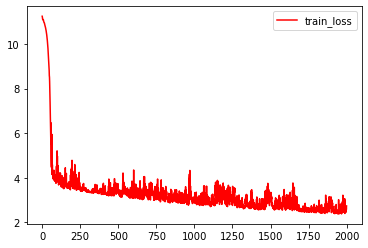

In [283]:
import matplotlib.pyplot as plt

figs, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], color='r', label='train_loss')
loss_ax.legend(loc='upper right')
plt.show()

In [284]:
model.evaluate(xTst, yTst)

10/10 [==============================] - 0s 299us/step


[3.9719882011413574, 3.9719882011413574]

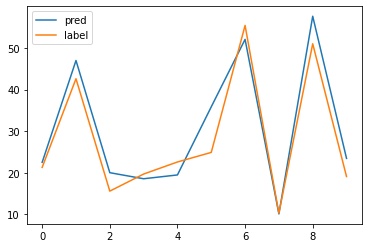

In [285]:
plt.plot(model.predict(xTst), label='pred')
plt.plot(yTst.reset_index(drop=True), label='label')
plt.legend()
plt.show()

훨씬 더 잘 맞는 것을 확인할 수 있음